Cell 1 – Setup imports + project root

In [8]:
# 02_embeddings_clustering.ipynb

import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import hdbscan
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans

PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.config import load_config
from src.data.loader import load_jobs
from src.embeddings.embedder import embed_texts, build_and_save_embeddings
from src.evaluation.metrics import internal_cluster_metrics
from src.clustering.clustering import kmeans_clusters, hdbscan_clusters, agglomerative_clusters
from src.data.preprocess import clean_text
from sentence_transformers import SentenceTransformer


sns.set(style="whitegrid")

cfg = load_config()
TEXT_COL = cfg["jobs"]["text_column"]

LABELS_PATH = PROJECT_ROOT / "results" / "clusters" / "kmeans_labels.npy"
CLEAN_VERSION = "boiler_v1_len50_cap3000"
EMB_PATH = PROJECT_ROOT / "results" / "embeddings" / f"embeddings_{CLEAN_VERSION}.npy"
JOBS_PATH = PROJECT_ROOT / "results" / "embeddings" / f"jobs_{CLEAN_VERSION}.parquet"


cfg


{'database': {'host': 'localhost',
  'port': 5432,
  'user': 'admin',
  'password': 'admin',
  'dbname': 'labor_db'},
 'jobs': {'table_name': 'job_postings',
  'text_column': 'description',
  'id_column': 'company_id'},
 'embeddings': {'model_name': 'sentence-transformers/all-MiniLM-L6-v2',
  'batch_size': 64,
  'device': 'cpu'},
 'clustering': {'n_clusters': 100, 'min_cluster_size': 100},
 'taxonomy': {'onet_path': '../data/onet_occupations.csv',
  'title_column': 'Title',
  'desc_column': 'Description',
  'code_column': 'O*NET-SOC Code',
  'top_k': 3,
  'similarity_threshold': 0.4}}

In [9]:
print("Using EMB_PATH =", EMB_PATH.resolve())


Using EMB_PATH = C:\Users\hisuk\labor-market-nlp-prototype\results\embeddings\embeddings_boiler_v1_len50_cap3000.npy


Cell 2 – Load jobs & build embeddings (or reuse cached)

In [11]:
jobs = load_jobs()
print("Jobs shape:", jobs.shape)

Jobs shape: (24164, 15)


In [13]:
import re

# ============================================================
# 0) Ensure output directories exist (versioned artifacts)
# ============================================================
EMB_PATH.parent.mkdir(parents=True, exist_ok=True)
JOBS_PATH.parent.mkdir(parents=True, exist_ok=True)
LABELS_PATH.parent.mkdir(parents=True, exist_ok=True)

# ============================================================
# 1) Load raw job postings
# ============================================================
TEXT_COL = "description"   # configured text field

jobs_raw = load_jobs()
print("Jobs shape (raw):", jobs_raw.shape)
assert TEXT_COL in jobs_raw.columns, f"Missing column: {TEXT_COL}"

# ============================================================
# 2) Boilerplate-aware text cleaning
# ============================================================
from src.data.preprocess import clean_text

jobs_clean = jobs_raw.copy()
jobs_clean[TEXT_COL] = jobs_clean[TEXT_COL].astype(str).map(lambda x: clean_text(x, mode="jobs"))


# Restore original text for rows that became empty after cleaning
empty_mask = jobs_clean[TEXT_COL].astype(str).str.strip().eq("")
print("Empty after cleaning:", int(empty_mask.sum()))
jobs_clean.loc[empty_mask, TEXT_COL] = jobs_raw.loc[empty_mask, TEXT_COL].astype(str)

# Remove very short texts (to avoid low-information embeddings)
MIN_LEN = 50
mask = jobs_clean[TEXT_COL].astype(str).str.len() > MIN_LEN
jobs_clean = jobs_clean.loc[mask].reset_index(drop=True)

texts = jobs_clean[TEXT_COL].astype(str).tolist()

print("Jobs shape (clean + filtered):", jobs_clean.shape)
print("Sample cleaned text:\n", texts[0][:400])

# ============================================================
# 3) Rebuild embeddings (always) and save
# ============================================================
# Option A (preferred): use the project utility if it supports passing cleaned texts
embeddings = build_and_save_embeddings(jobs_clean, EMB_PATH, texts=texts)

print("Embeddings shape:", embeddings.shape)

# Safety check
assert embeddings.shape[0] == len(jobs_clean), "Embedding count does not match jobs_clean rows"

# Persist cleaned jobs so all downstream steps stay aligned
jobs_clean.to_parquet(JOBS_PATH, index=False)
print("✅ Saved cleaned jobs to:", JOBS_PATH)

# ============================================================
# 4) Rebuild KMeans labels (always) and save
# ============================================================
# Pull cluster count from config for reproducibility
N_CLUSTERS = cfg["clustering"]["n_clusters"]

km = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init="auto")
km_labels = km.fit_predict(embeddings)

np.save(LABELS_PATH, km_labels)
print("✅ Saved KMeans labels to:", LABELS_PATH)
print("Labels shape:", km_labels.shape)

# ============================================================
# 5) Convenience objects for downstream cells
# ============================================================
jobs = jobs_clean   # downstream cells now always use cleaned data

print("\nDone. Using cleaned jobs, rebuilt embeddings, and rebuilt labels.")


Jobs shape (raw): (24164, 15)
Empty after cleaning: 246
Jobs shape (clean + filtered): (23839, 15)
Sample cleaned text:
 At IBM, we do more than work. We create. We create as technologists, developers, and engineers. We create with our partners. We create with our competitors. If you're searching for ways to make the world work better through technology and infrastructure, software and consulting, then we want to work with you. We're here to help every creator turn their "what if" into what is. Let's create somethin


Batches: 100%|██████████| 373/373 [18:27<00:00,  2.97s/it]


Embeddings shape: (23839, 384)
✅ Saved cleaned jobs to: C:\Users\hisuk\labor-market-nlp-prototype\results\embeddings\jobs_boiler_v1_len50_cap3000.parquet
✅ Saved KMeans labels to: C:\Users\hisuk\labor-market-nlp-prototype\results\clusters\kmeans_labels.npy
Labels shape: (23839,)

Done. Using cleaned jobs, rebuilt embeddings, and rebuilt labels.


Number of clusters: 100


cluster  speciality_clean 
0        Unknown              33
         IT Consulting         4
         IT Staffing           2
1        Unknown              22
         Packaging             3
                              ..
98       Youth Development     5
         Fundraising           4
99       Unknown              34
         Animal Welfare        2
         Pet Food              2
Name: count, Length: 300, dtype: int64

0    122
1    128
2    294
3    314
4    394
5    263
6    227
7    279
8    244
9    346
Name: count, dtype: int64

Saved to: C:\Users\hisuk\labor-market-nlp-prototype\results\graphs\cluster_size_distribution.png


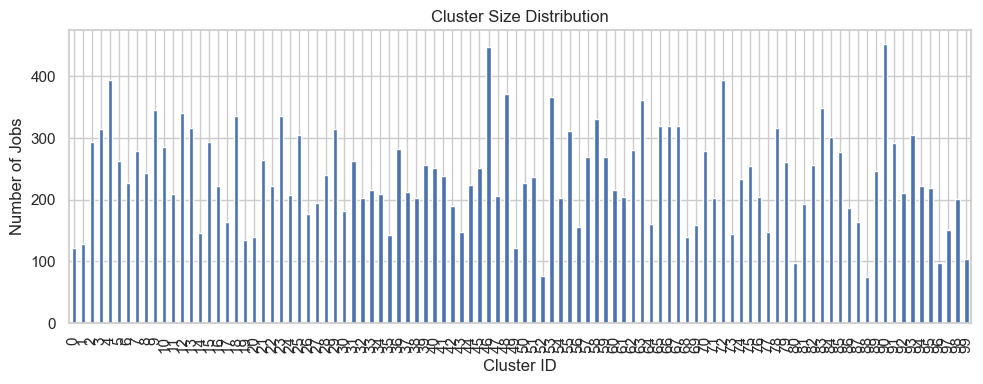

{'silhouette': 0.028641000390052795, 'davies_bouldin': 4.657473506036765, 'n_clusters': 100}
✅ Saved jobs_with_labels to: C:\Users\hisuk\labor-market-nlp-prototype\results\embeddings\jobs_boiler_v1_len50_cap3000.parquet


cluster  speciality                    
0        IT Consulting                     4
         IT Staffing                       2
         AIDS vaccine                      1
1        Packaging                         3
         packaging                         3
                                          ..
98       Fundraising                       4
         Financial Services                3
99       Animal Welfare                    2
         Pet Food                          2
         Veterinary Practice Management    2
Name: count, Length: 300, dtype: int64

,company_id,speciality,name,description
435,3364,Financial Services,Fiserv,"Fiserv, Inc. is a leading global technology pr..."
468,3608,GPU-accelerated computing,NVIDIA,"Since its founding in 1993, NVIDIA (NASDAQ: NV..."
763,5140,IT Consulting,Virtusa,Virtusa Corporation provides digital engineeri...
1444,9732,Legacy Systems Sustainment,VSE Corporation,Connected to the Mission: LAND + SEA + AIR VSE...
1487,10028,Engineering & Design,Belcan,"Belcan is a global supplier of engineering, ma..."
1599,11067,IT Professional Services,"Pinnacle Group, Inc.",Pinnacle Group is a leading provider of inform...
1624,11229,Consulting,Vaco,The speed of change requires the talent of peo...
1726,12164,Engineering,STV,STV offers professional services for the infra...
2395,20016,CCRC,Vi,"Vi is an owner, operator, and developer of exc..."
2689,23976,AIDS vaccine,IAVI,Translating scientific discoveries into afford...


In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# ✅ KMeans has no noise label (-1)
print("Number of clusters:", int(len(set(km_labels))))

# ✅ Always attach labels to jobs_clean so rows align with embeddings
jobs_with_labels = jobs_clean.copy()
jobs_with_labels["cluster"] = km_labels

# Top-3 specialties per cluster
if "speciality" in jobs_with_labels.columns:
    jobs_with_labels["speciality_clean"] = jobs_with_labels["speciality"].fillna("Unknown")
    top3 = (
        jobs_with_labels
        .groupby("cluster")["speciality_clean"]
        .value_counts()
        .groupby(level=0)
        .head(3)
    )
    display(top3)

# Cluster size distribution
cluster_sizes = pd.Series(km_labels).value_counts().sort_index()
display(cluster_sizes.head(10))

plt.figure(figsize=(10, 4))
cluster_sizes.plot(kind="bar")
plt.title("Cluster Size Distribution")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Jobs")
plt.tight_layout()

RESULTS_DIR = PROJECT_ROOT / "results"
GRAPH_DIR = RESULTS_DIR / "graphs"

GRAPH_DIR.mkdir(parents=True, exist_ok=True)
save_path = GRAPH_DIR / "cluster_size_distribution.png"

plt.savefig(save_path, dpi=200, bbox_inches="tight")
print("Saved to:", save_path)
plt.show()

# Internal clustering metrics (may still be low for text data)
metrics = internal_cluster_metrics(embeddings, km_labels)
print(metrics)

# ✅ Save labeled jobs using JOBS_PATH (includes versioning)
jobs_with_labels.to_parquet(JOBS_PATH, index=False)
print("✅ Saved jobs_with_labels to:", JOBS_PATH)

# Inspect top job titles per cluster
if "speciality" in jobs_with_labels.columns:
    display(
        jobs_with_labels.groupby("cluster")["speciality"]
        .value_counts()
        .groupby(level=0)
        .head(3)
    )

# Inspect a single cluster
cluster_id = 0
cluster_sample = jobs_with_labels[jobs_with_labels["cluster"] == cluster_id].head(10)

id_col = cfg["jobs"]["id_column"] if "jobs" in cfg and "id_column" in cfg["jobs"] else None
cols = [c for c in [id_col, "speciality", "name", TEXT_COL] if c and c in cluster_sample.columns]

display(cluster_sample[cols] if cols else cluster_sample.head(10))
